# Overview

All scenario's notebooks have the same structure:

- [Description of the scenario](#description)
- [Analysis of the calibration step in the real world and obtain calibration values for SimGrid's execution](#calibration)
- [Analysis of the execution of the scenario and comparison with the predicted results obtained in SimGrid](#comparison)

# Initialization code

In [2]:
library(viridis)
library(ggplot2)
library(plotly)
library(plyr)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/calvin-microbenchmarks/comparison"

<a id='description'></a>
# 3rd scenario results

This file describes the steps used to perform the experiment, and provides visualizations of the results.

## Scenario

The scenario consists in 2 computing node. The datasource will send requests to the first computing node.
Work amounts (loop iterations) is changing on the second compute node and is static on the first node. The scenario is launched several times with different amount of works. The first node once done processing the request sends it to the second node through rabbitmq, which will in turn send the result to the sink once finished as in scenario 1.

The experiment lasts for 5 minutes and is repeated 4 times for each work amount (40*4=160 launches) to limit random effects.

Here are the parameters used:

```
----------------------------------------------------
PARAMETERS:
suffix: reprodscen3
Parallelization degree: 8
HostLogPath: /home/ccourageuxsudan/logs_expe/goLogs/reprod_scenario3_2021-04-09_09-11-45/
nbIters: start=1, end=80000001, iter=2000000
Samples: 4
Timestamp file: /go/src/app/timestamps/default5TimeStamps.csv
First core used: 0
----------------------------------------------------

```

## Reproduce

This scenario was launched on Grid'5000's parasilo cluster.

Example of node reservation: `oarsub -p "cluster='paravance'" -l host=4,walltime=6 -I`

The experiment was launched using: `repoPath="/home/ccourageuxsudan/SGMicroservices/calvin-microbenchmarks/rabbitmqGo/" onG5K=1 run=1 scenario=1 bash launcherReproduce.s`

## Output

Output logs for this scenario can be found under:

- For the calibration step: `results_reprod/reprod_calib_2021-04-09_09-11-45/`
- For the execution: `results_reprod/reprod_scenario3_2021-04-09_09-11-45/`

## Synthetic Loads


We use 2 synthetic workloads to perform our experiments:

- Calibration workload: one request triggered every 3 seconds for 5 minutes (300 seconds)
- Execution workload: varying workload generated using LIMBO, with 3 spikes


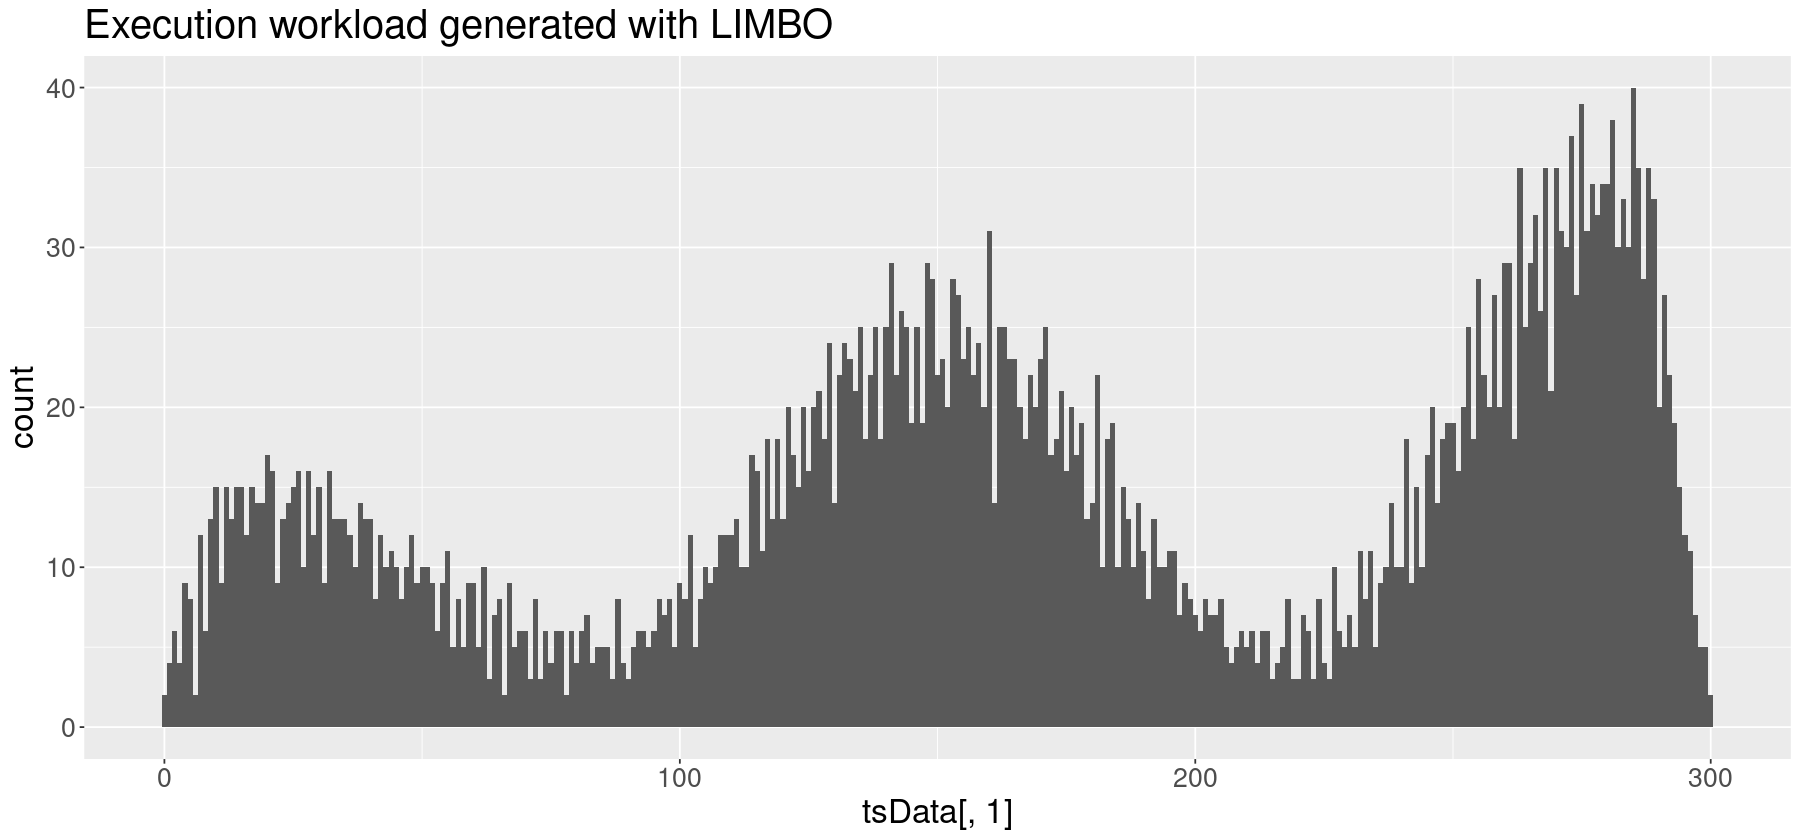

In [26]:
options(repr.plot.width=15, repr.plot.height=7)

tsData <- read.csv("./files/tsload.csv")

colnames(tsData) <- c("timestamp")

ggplot(tsData, aes(x=tsData[,1])) +
    geom_histogram(binwidth=1) +
    theme(text = element_text(size = 20)) + 
    ggtitle("Execution workload generated with LIMBO")

# Load Datasets

In [22]:
##### CALIBRATION
data_calibration <- as_tibble(read.csv("results_reprod/reprod_calib_2021-04-09_09-11-45/3_aggrResults_1-10000000-100000002_4.csv"))

# preprocess to obtain timestamps as seconds instead of microseconds
data_calibration$timestampSec <- as.numeric(as.character(data_calibration$timestamp)) / 1e9
data_calibration$computeDurSec <- as.numeric(as.character(data_calibration$computeDur)) / 1e9
data_calibration$computeNode <- sub("\\_.*", "", data_calibration$serviceName)
summary(data_calibration)


data_calibration_sg <- as_tibble(read.csv("results_reprod/sg_calib/sg_cal_scenario3.csv"))
summary(data_calibration_sg)

###### LOAD EXECUTION
data_SG_load <- as_tibble(read.csv("results_reprod/sg_run/sg_load_scenario3.csv"))
data_load_RW <- as_tibble(read.csv("results_reprod/reprod_scenario3_2021-04-09_09-11-45/3_aggrResults_1-2000000-80000001_4.csv"))
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9
data_load_RW$computeNode <- sub("\\_.*", "", data_load_RW$serviceName)
summary(data_load_RW)


 serviceName            nbIter           timestamp          totDurInServ     
 Length:8800        Min.   :1.00e+00   Min.   :0.000e+00   Min.   :    1621  
 Class :character   1st Qu.:1.00e+06   1st Qu.:7.425e+10   1st Qu.:  351749  
 Mode  :character   Median :1.00e+06   Median :1.485e+11   Median :  508980  
                    Mean   :2.55e+07   Mean   :1.485e+11   Mean   : 8335558  
                    3rd Qu.:5.00e+07   3rd Qu.:2.228e+11   3rd Qu.:16092520  
                    Max.   :1.00e+08   Max.   :2.970e+11   Max.   :53800814  
   computeDur          parExec       totReqProcessed   scenario        
 Min.   :     252   Min.   :0.0000   Min.   : 0.00   Length:8800       
 1st Qu.:  349543   1st Qu.:0.0000   1st Qu.:24.75   Class :character  
 Median :  505352   Median :0.0000   Median :49.50   Mode  :character  
 Mean   : 8333049   Mean   :0.2573   Mean   :49.50                     
 3rd Qu.:16089594   3rd Qu.:1.0000   3rd Qu.:74.25                     
 Max.   :53797099   Ma

       ts              qArr        instArr       startEx        endEx       
 Min.   :  4.00   Min.   :  4   Min.   :  4   Min.   :  4   Min.   :  4.00  
 1st Qu.: 76.02   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76.02  
 Median :151.00   Median :151   Median :151   Median :151   Median :151.00  
 Mean   :151.01   Mean   :151   Mean   :151   Mean   :151   Mean   :151.01  
 3rd Qu.:226.00   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226.00  
 Max.   :298.03   Max.   :298   Max.   :298   Max.   :298   Max.   :298.03  
     flops              serv          
 Min.   :   91000   Length:2178       
 1st Qu.:  414200   Class :character  
 Median :  414200   Mode  :character  
 Mean   : 8332600                     
 3rd Qu.:16251000                     
 Max.   :32411000                     

 serviceName            nbIter           timestamp          totDurInServ      
 Length:1428440     Min.   :       1   Min.   :0.000e+00   Min.   :     1264  
 Class :character   1st Qu.: 1000000   1st Qu.:1.180e+11   1st Qu.:   393519  
 Mode  :character   Median : 1000000   Median :1.679e+11   Median :   534212  
                    Mean   :20500000   Mean   :1.728e+11   Mean   : 11752237  
                    3rd Qu.:40000001   3rd Qu.:2.600e+11   3rd Qu.: 13758854  
                    Max.   :80000001   Max.   :3.008e+11   Max.   :296539326  
   computeDur           parExec        totReqProcessed   scenario        
 Min.   :      228   Min.   :-1.0000   Min.   :   0    Length:1428440    
 1st Qu.:   391533   1st Qu.: 0.0000   1st Qu.:1088    Class :character  
 Median :   531260   Median : 0.0000   Median :2177    Mode  :character  
 Mean   : 11703500   Mean   : 0.6292   Mean   :2177                      
 3rd Qu.: 13756746   3rd Qu.: 0.0000   3rd Qu.:3266                      
 Ma

<a id='calibration'></a>
# Calibration Step

We perform it with one compute node only since they would execute on different cores and would both give very similar output.

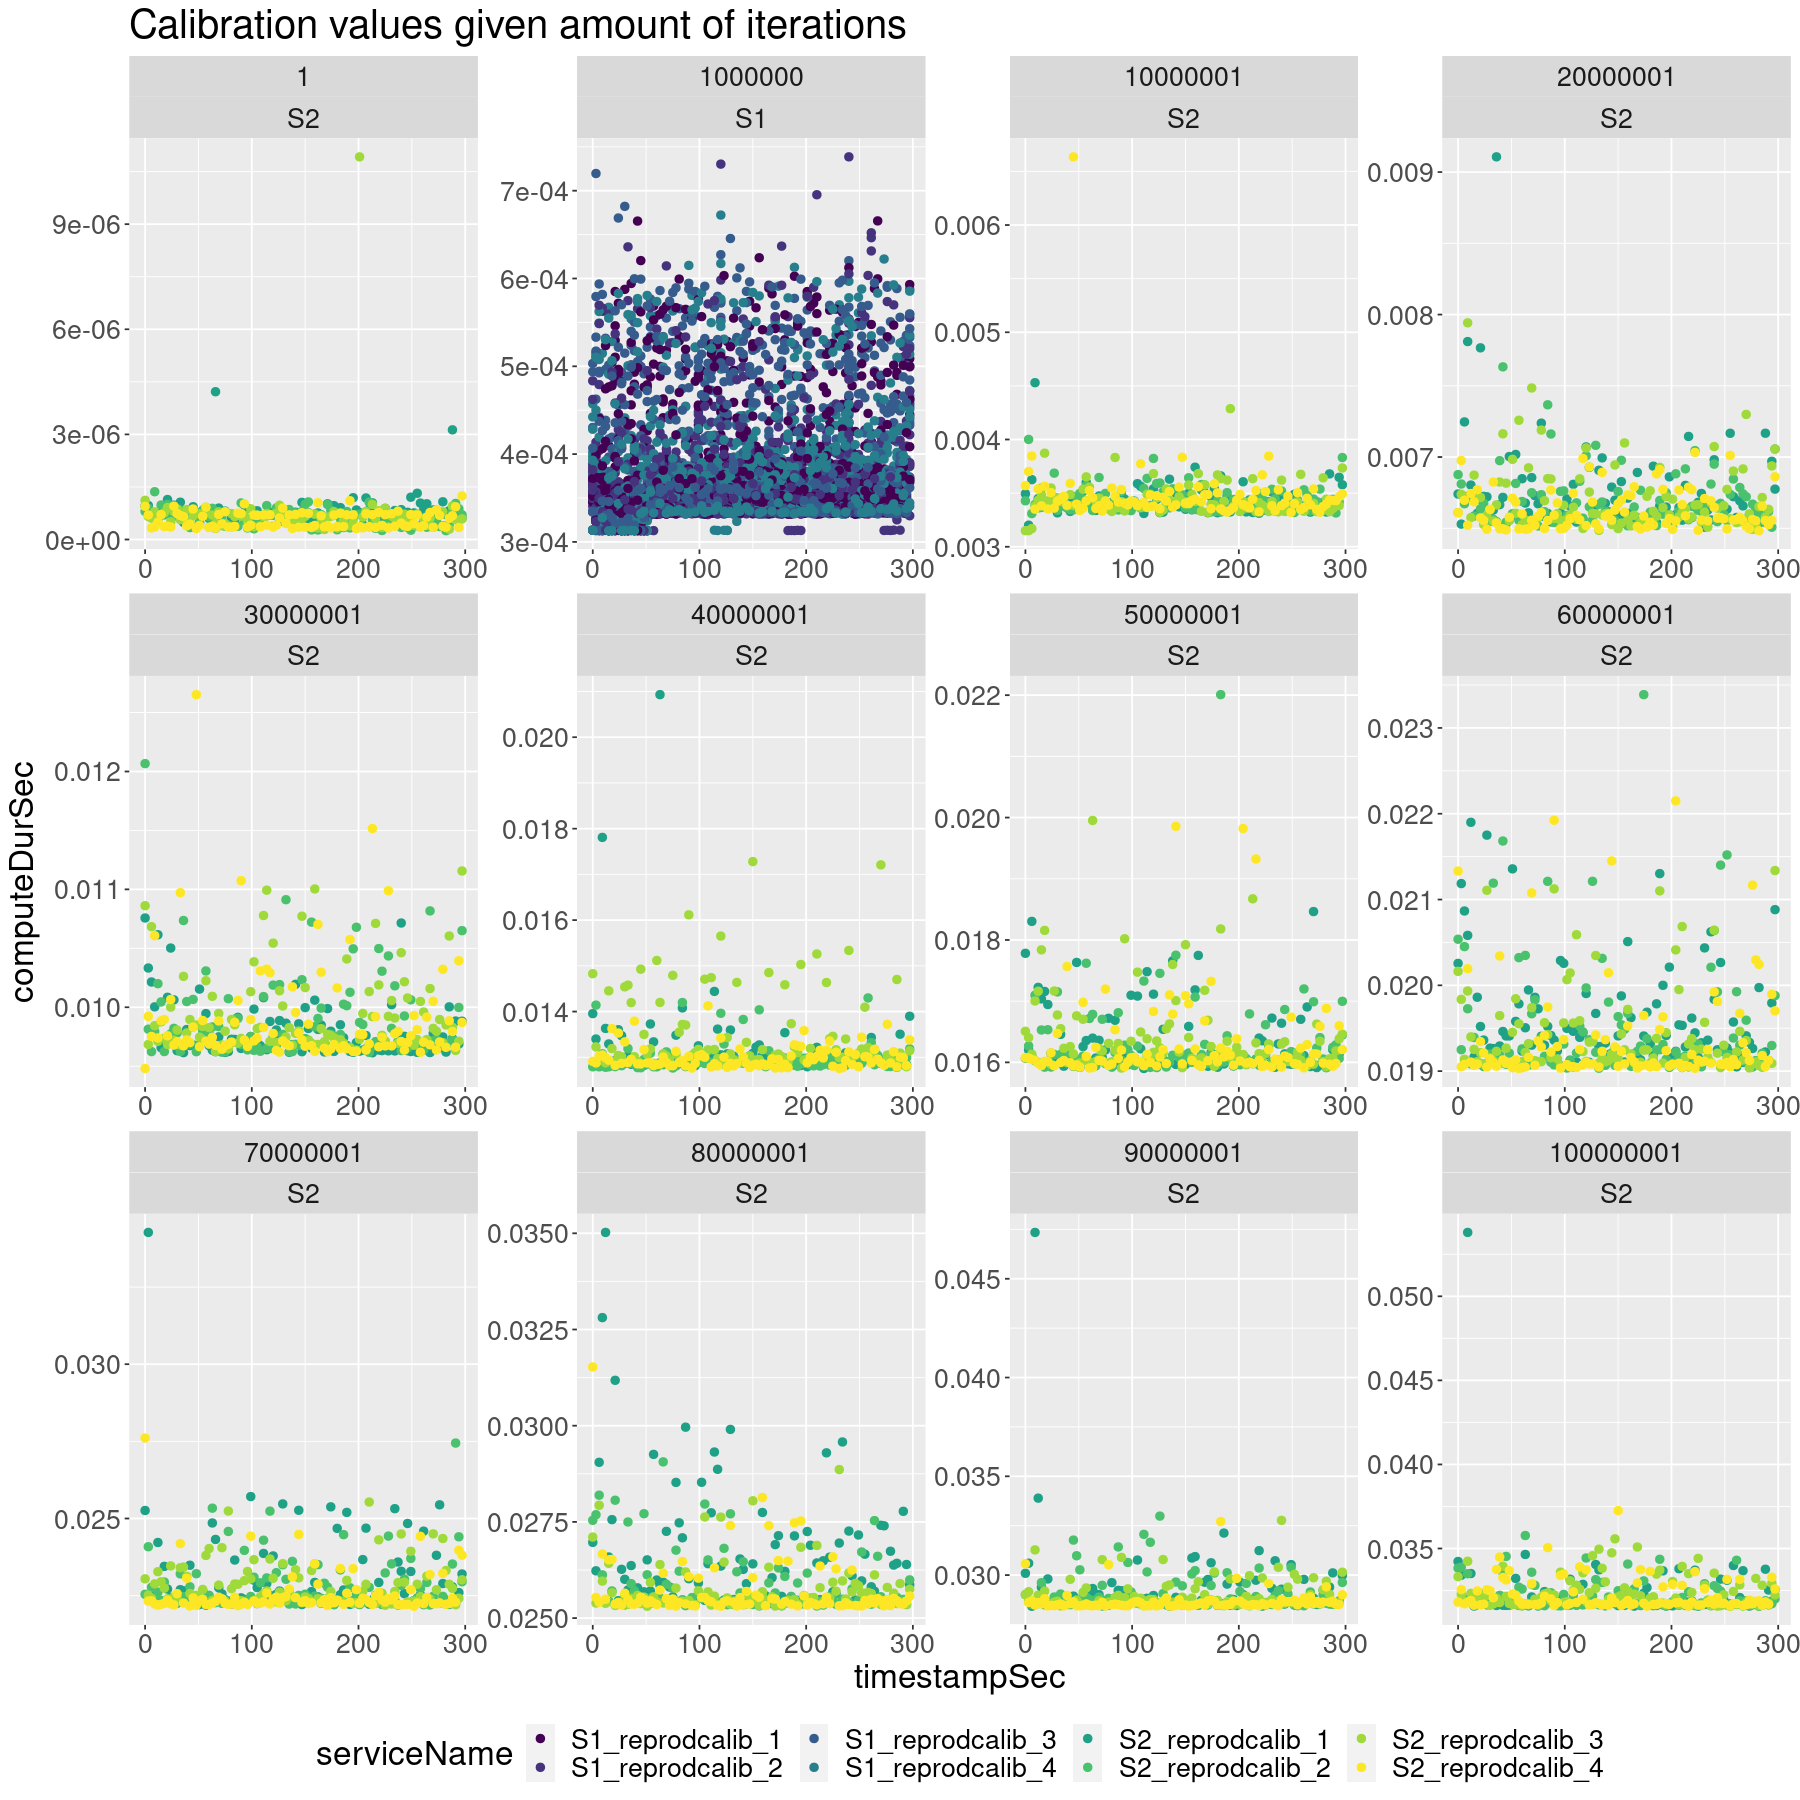

In [5]:
options(repr.plot.width=15, repr.plot.height=15)
ggplot(data_calibration, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=2)+
    ggtitle("Calibration values given amount of iterations")+
    facet_wrap(nbIter ~ computeNode, scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) 

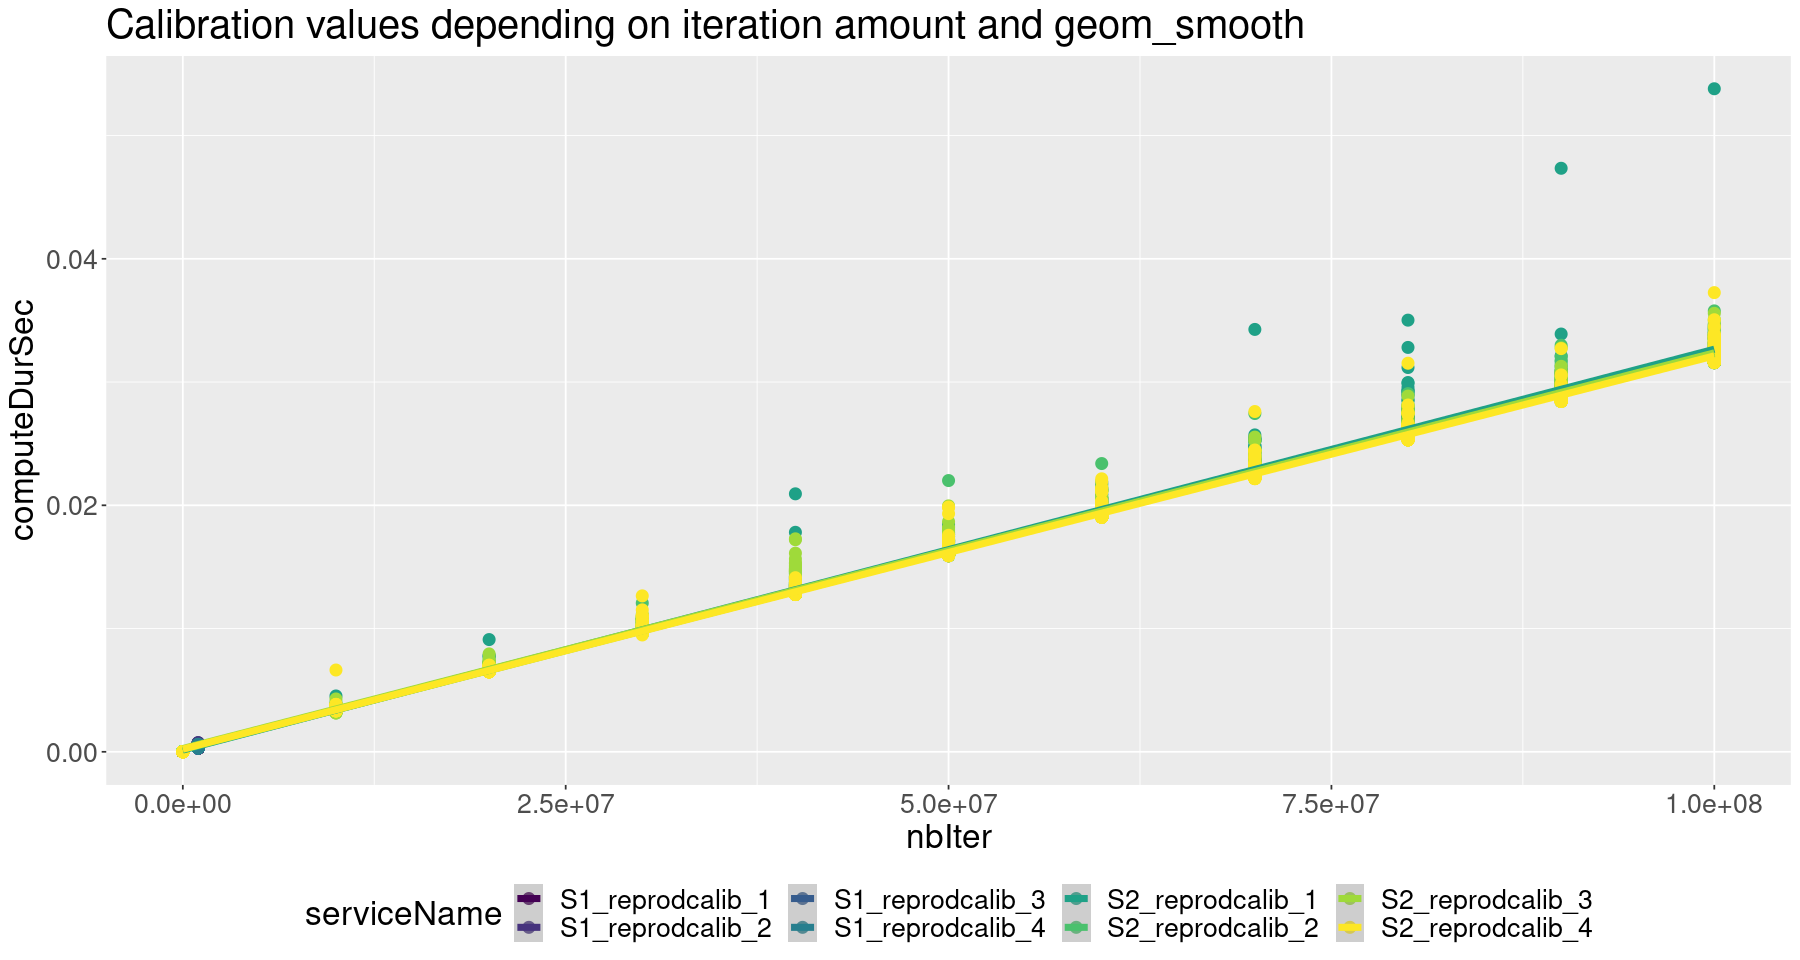

In [7]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data_calibration, aes(x=nbIter, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) + 
    ggtitle("Calibration values depending on iteration amount and geom_smooth")+
    geom_smooth(formula = y ~ x, method='lm', size=2)

## Linear regression to obtain calibration values

Given the previous graph, we can clearly observe (as expected) a linear relationship between the amount of work of the compute node, and the duration to execute a request. Thus we can use a linear regression to estimate the duration of a request given an amount of work (as a number of iterations). This value will then be used to calibrate our SimGrid code.

In [8]:
calibrationRegression = lm(computeDurSec ~ nbIter, data=data_calibration)
summary(calibrationRegression)


Call:
lm(formula = computeDurSec ~ nbIter, data = data_calibration)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0008465 -0.0000907 -0.0000631  0.0000291  0.0213843 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 9.100e-05  7.775e-06    11.7   <2e-16 ***
nbIter      3.232e-10  1.858e-13  1739.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005783 on 8798 degrees of freedom
Multiple R-squared:  0.9971,	Adjusted R-squared:  0.9971 
F-statistic: 3.025e+06 on 1 and 8798 DF,  p-value: < 2.2e-16


The obtained equation is:
### ```dur = nbIter*3.232*10**(-10)+9.100*10**(-5)``` 

## Utility function to obtain duration from nbIter

In [9]:
nbIter_to_duration <- function(nbIter) {
  return (nbIter*3.232*10**(-10)+9.100*10**(-5))
}

# utilitary function
nbIter_to_duration_to_SG <- function(start, end, iter, fact=1) {
    for(i in seq(from=start, to=end, by=iter)){
        cat(paste(trunc(fact*nbIter_to_duration(i)*10^9)," "))
    }
}

# example
print(nbIter_to_duration(2.5*10**8))
print(nbIter_to_duration(5*10**8))
print(nbIter_to_duration(7.5*10**8))

[1] 0.080891
[1] 0.161691
[1] 0.242491


## Calibration comparison between real world data and SimGrid

In [13]:
start=1
end=100000002
iter=10000000

nbIter_to_duration_to_SG(start, end, iter)

91000  3323000  6555000  9787000  13019000  16251000  19483000  22715000  25947000  29179000  32411000  

In [11]:
# compute fixed cost of 1000000 loops for compute node 1

start=1000000
end=1000000
iter=1

nbIter_to_duration_to_SG(start, end, iter)

414200  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_cal_scenario3.csv
for i in 91000  3323000  6555000  9787000  13019000  16251000  19483000  22715000  25947000  29179000  32411000
do
    echo "Calibration for iterAmount=$i"
    scenario=3 fixedCost=414200 parDeg=8 tsFile=../rabbitmqGo/timestamps/tsCal.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_cal_scenario3.csv
done
```

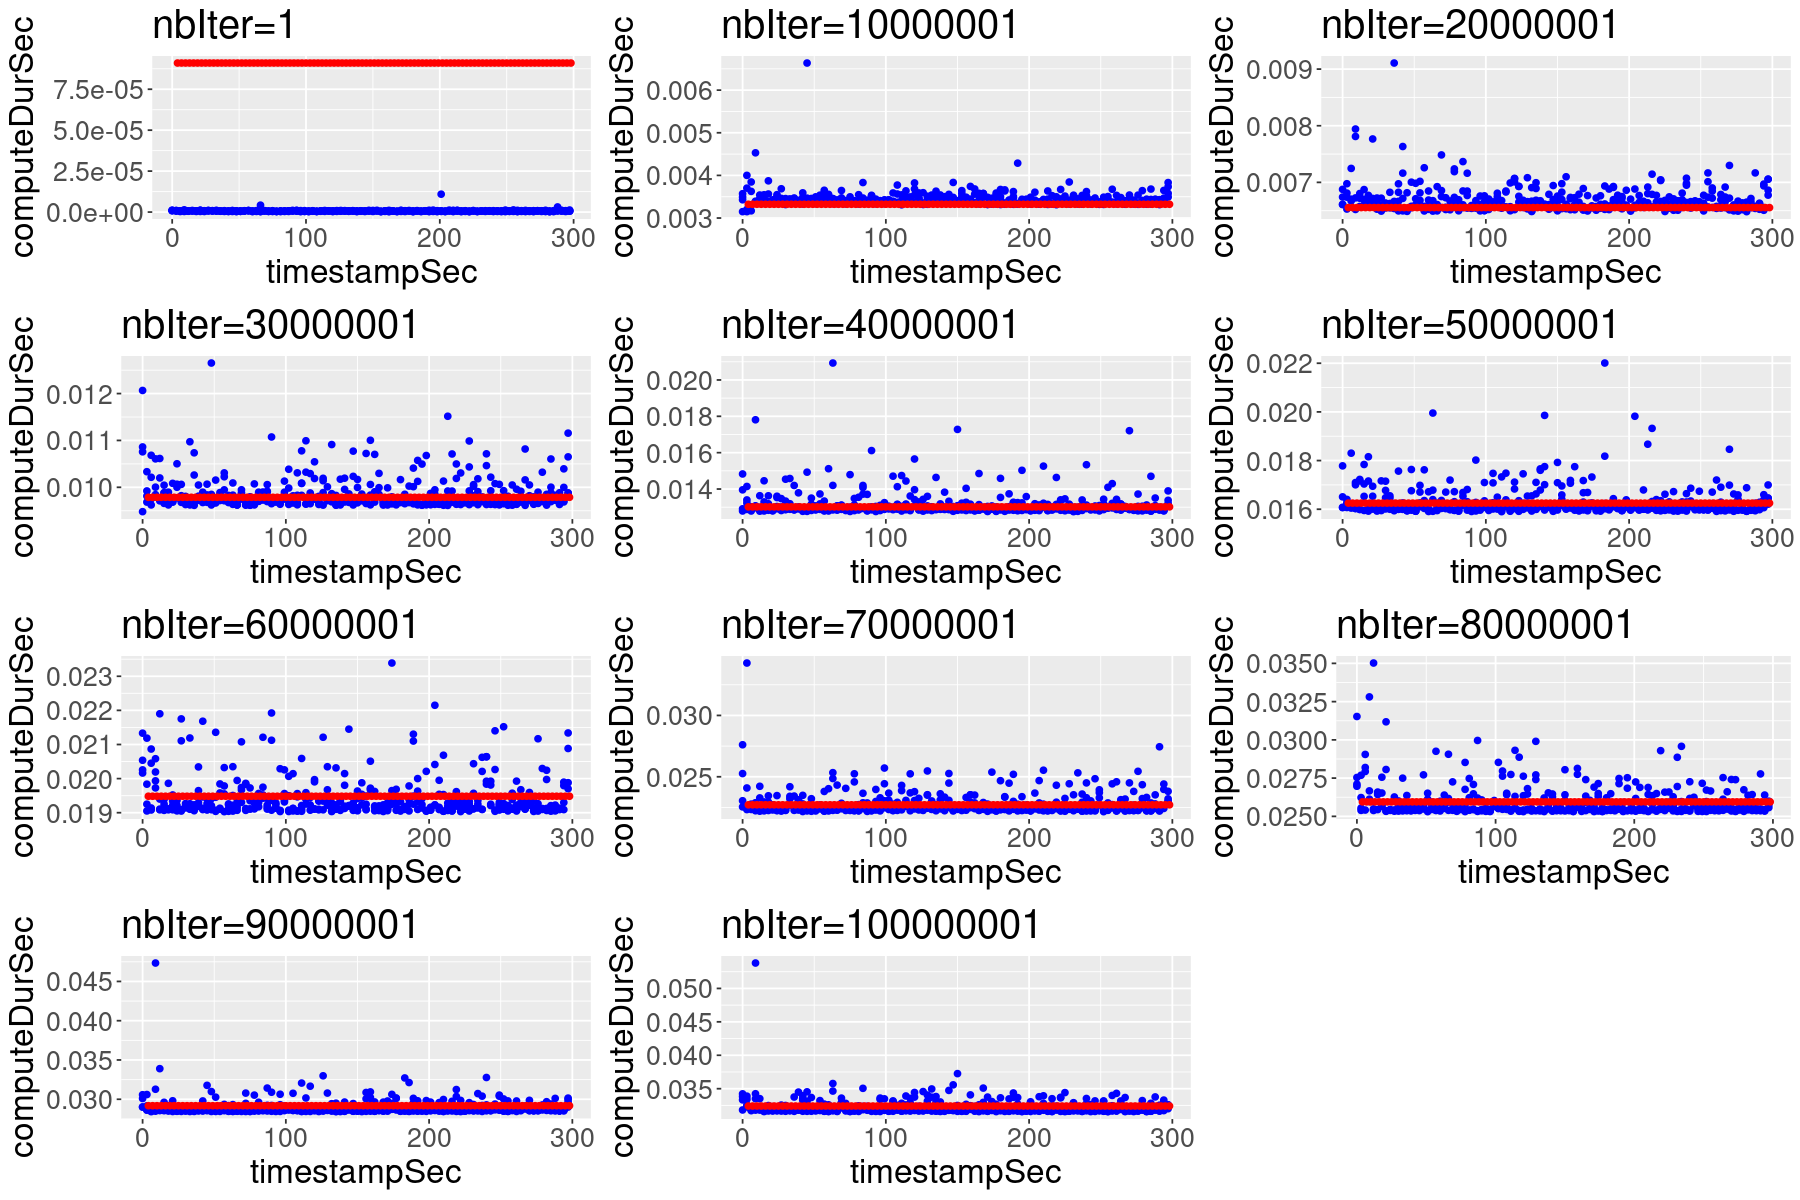

In [18]:
options(repr.plot.width=15, repr.plot.height=10)
P <- list()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red")+
        labs(title=sprintf("nbIter=%d",i))+
        theme(text = element_text(size = 20))+ 
        scale_color_viridis(discrete = TRUE, option = "D")+
        scale_fill_viridis(discrete = TRUE) 
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))

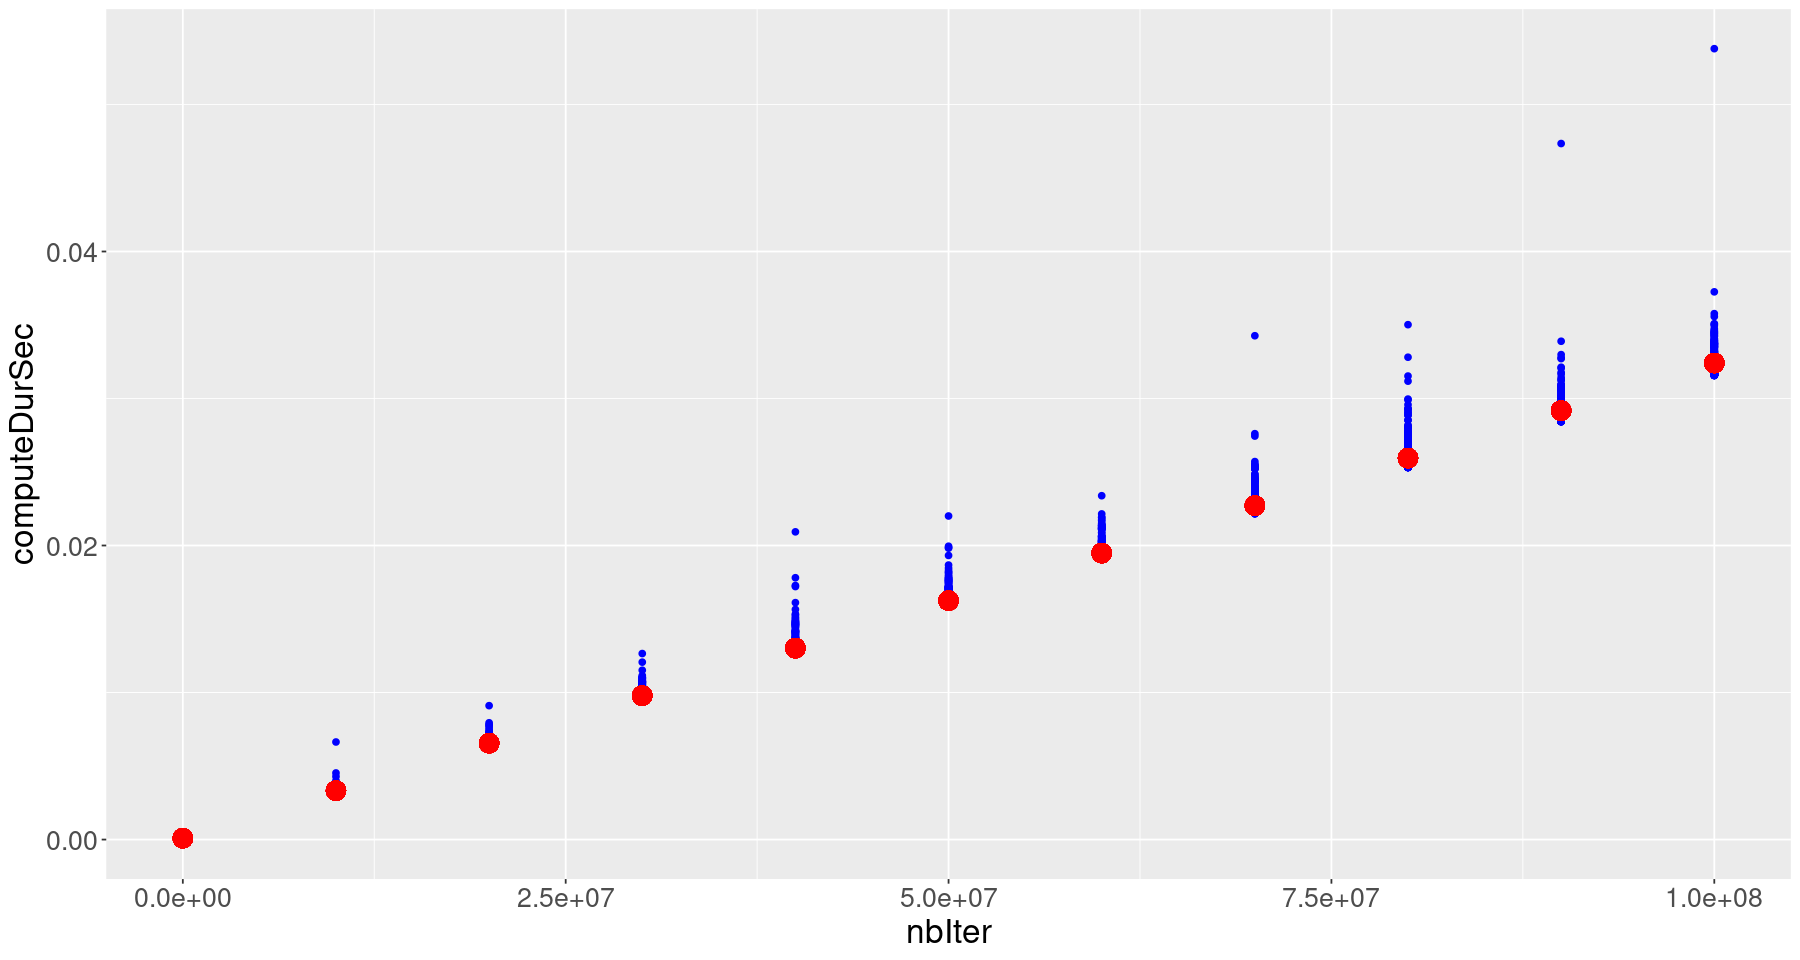

In [19]:

options(repr.plot.width=15, repr.plot.height=8)
P <- list()
g <- ggplot()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    tmpsg$nb <- i

    g <- g +
        geom_point(data = tmpG5K, aes(x=nbIter, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=nb, y=endEx-startEx), color = "red", size=5)+
        theme(text = element_text(size = 20))
    P <- c(P, list(g))
    
}
g

<a id='comparison'></a>
# Execution comparison


In [21]:
# obtain flop amount for 1GF nodes in SimGrid

start=1
end=80000001
iter=2000000

nbIter_to_duration_to_SG(start, end, iter)

# fixed cost didn't change since calibration

91000  737400  1383800  2030200  2676600  3323000  3969400  4615800  5262200  5908600  6555000  7201400  7847800  8494200  9140600  9787000  10433400  11079800  11726200  12372600  13019000  13665400  14311800  14958200  15604600  16251000  16897400  17543800  18190200  18836600  19483000  20129400  20775800  21422200  22068600  22715000  23361400  24007800  24654200  25300600  25947000  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_load_scenario3.csv
for i in 91000  737400  1383800  2030200  2676600  3323000  3969400  4615800  5262200  5908600  6555000  7201400  7847800  8494200  9140600  9787000  10433400  11079800  11726200  12372600  13019000  13665400  14311800  14958200  15604600  16251000  16897400  17543800  18190200  18836600  19483000  20129400  20775800  21422200  22068600  22715000  23361400  24007800  24654200  25300600  25947000 
do
    echo "Calibration for iterAmount=$i"
    scenario=3 parDeg=8 fixedCost=414200 tsFile=default5TimeStamps.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_load_scenario3.csv
done
```

# Time spent in first node

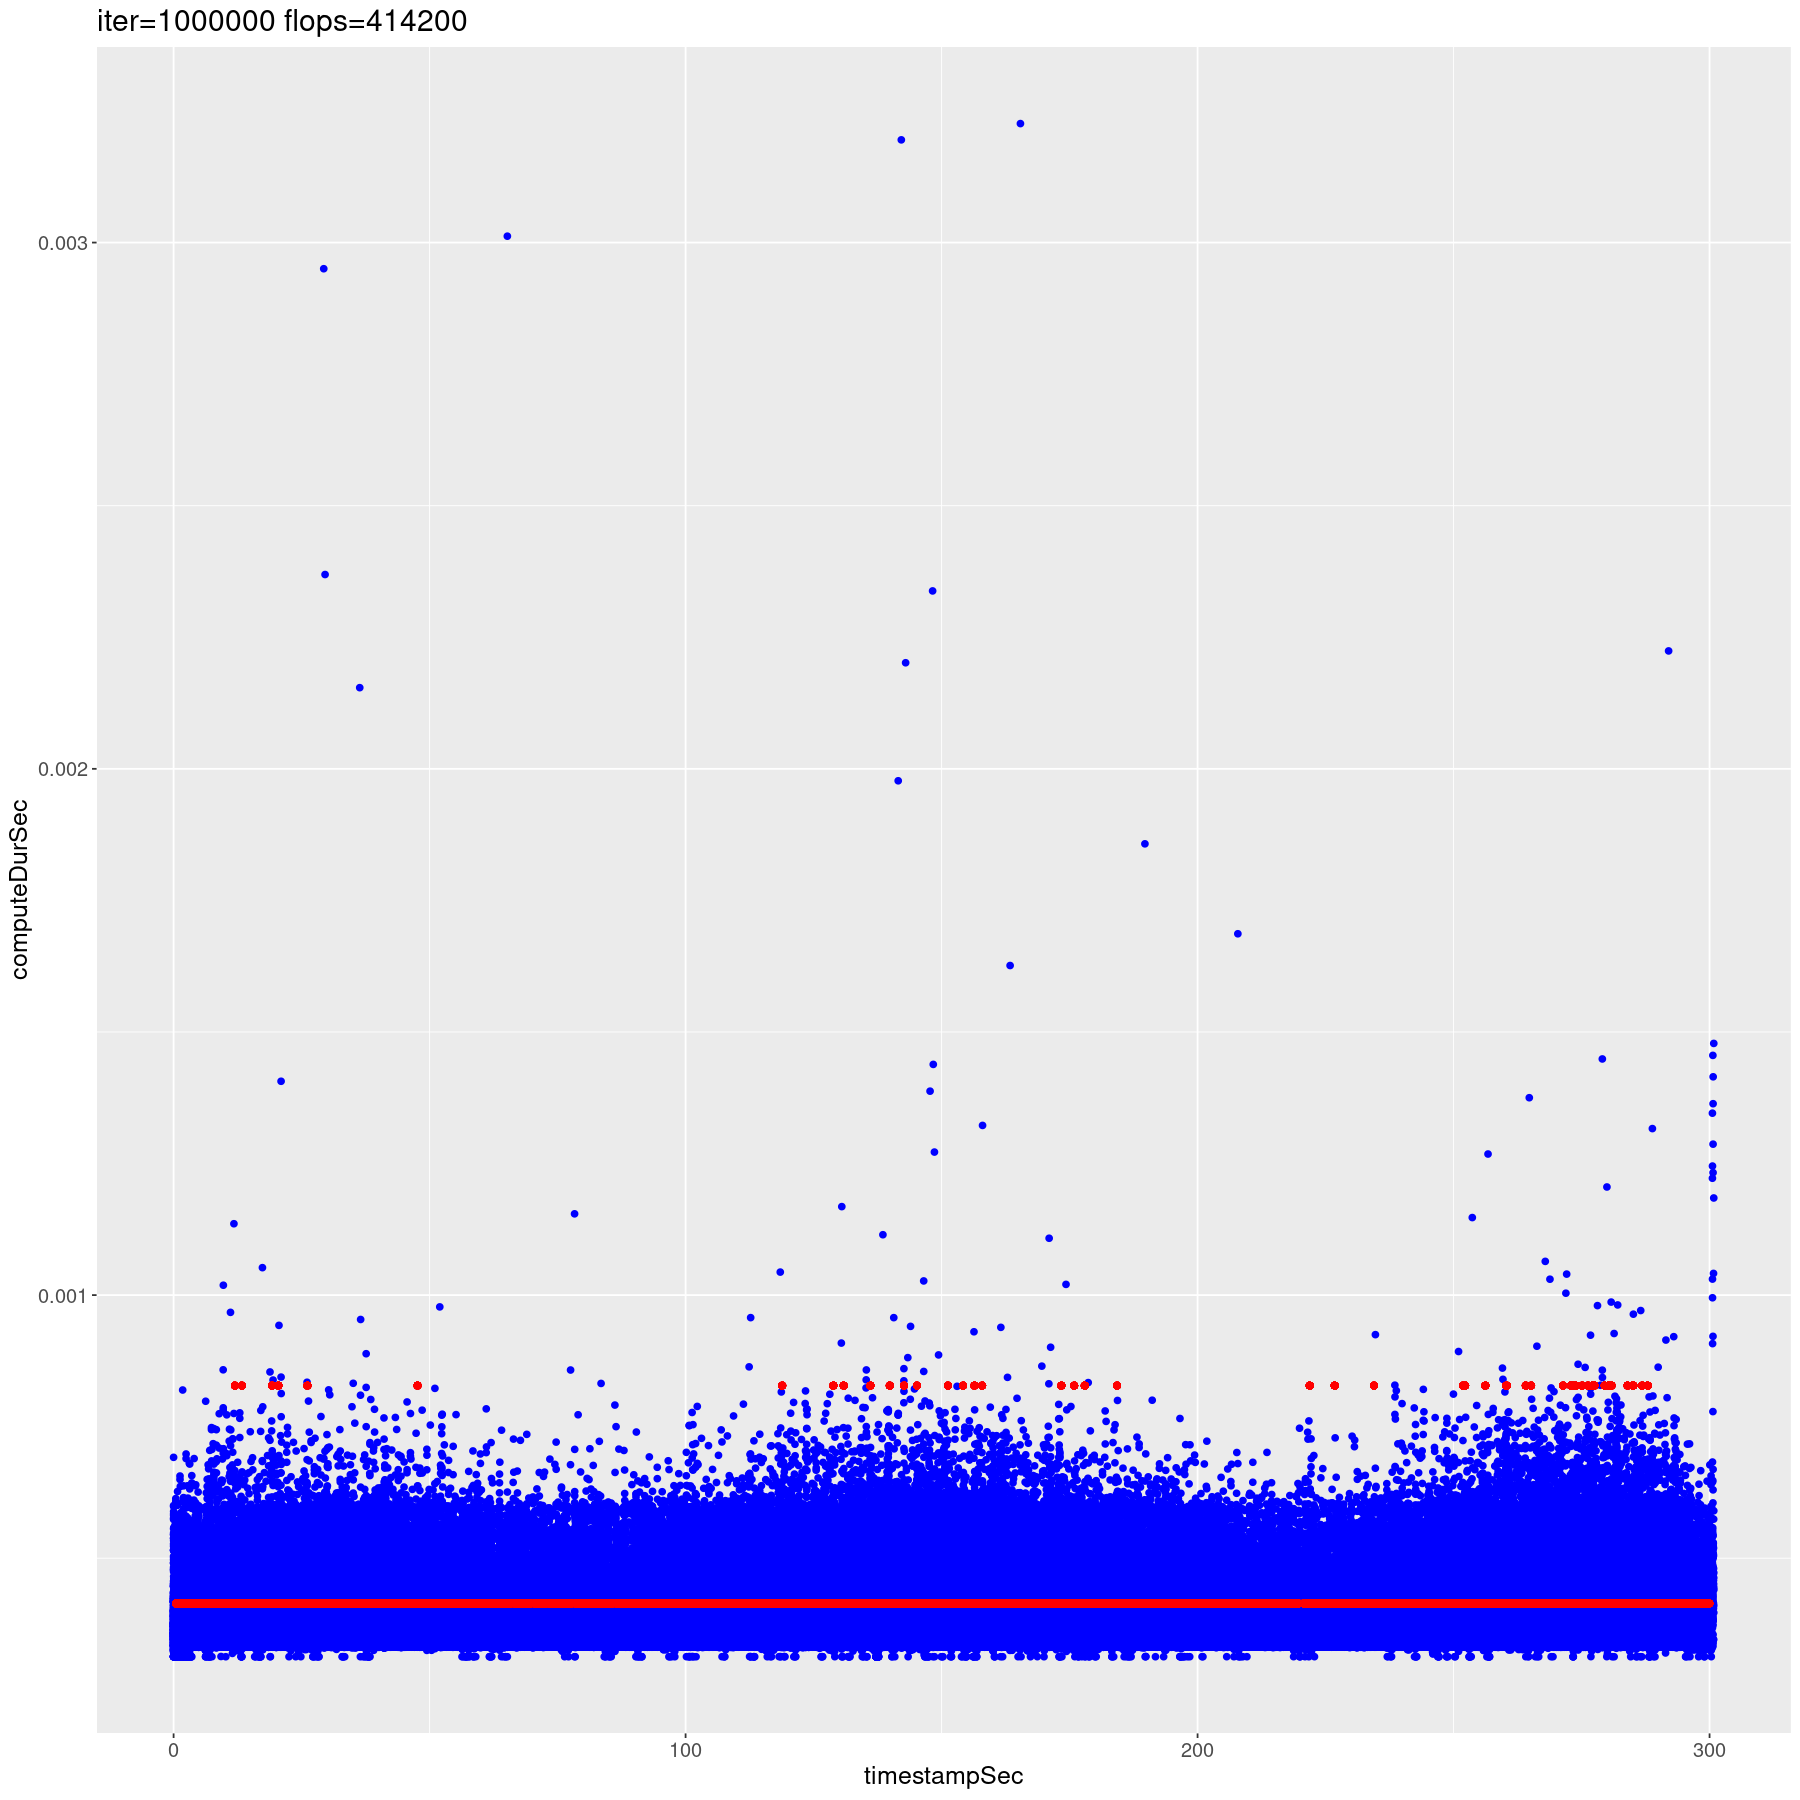

In [28]:

options(repr.plot.width=15, repr.plot.height=15)

P <- list()
for(i in seq(from=1000000, to=1000000, by=1)){
    tmpsg <- subset(data_SG_load, serv=="service1" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S1" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P))


# Time spent in second node

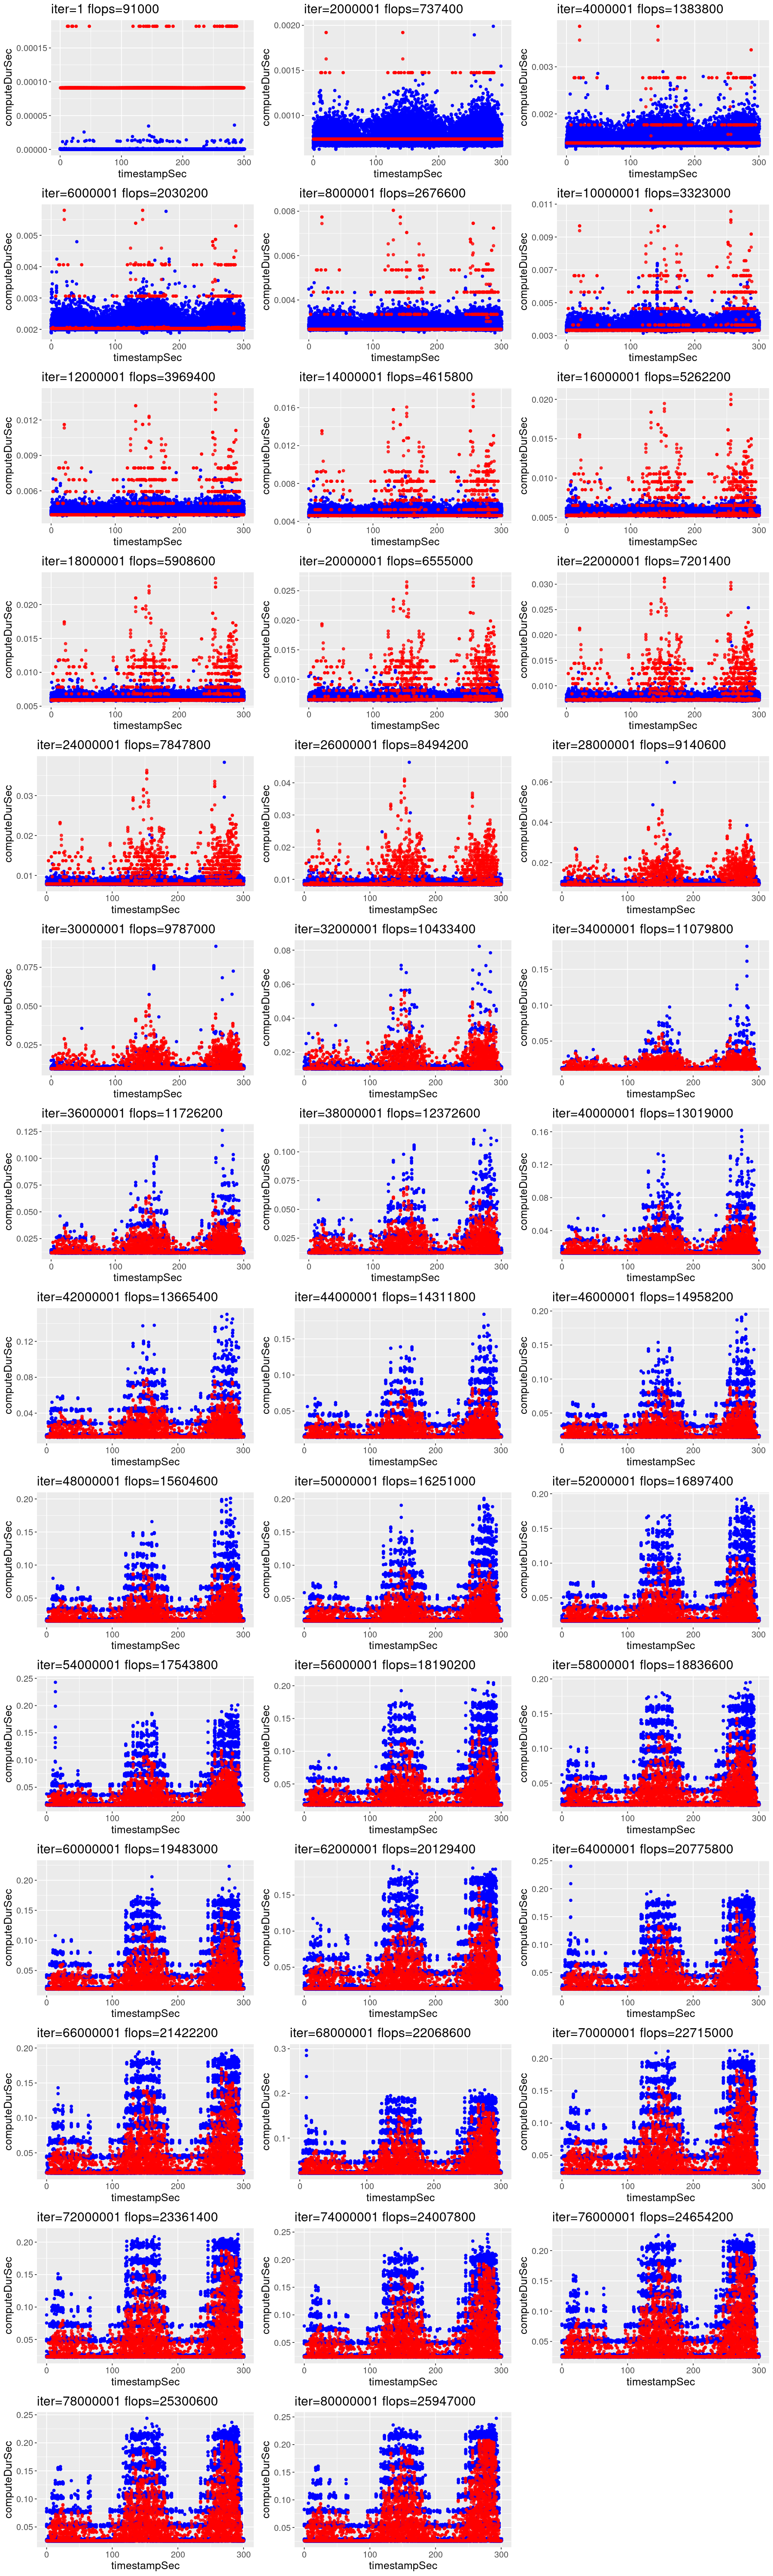

In [24]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, serv=="service2" & flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, computeNode == "S2" & nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))
